In [499]:
import numpy as np
from financepy.utils import OptionTypes
from financepy.products.equity import bs_value, bs_delta
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [500]:
# Parameters
S = np.array([100])  # Initial share price (as an array)
K = 100              # Strike price
r = 0.05             # Risk-free interest rate
q = 0.0              # Dividend yield
sigma = 0.2          # Volatility
T = 1.0              # Time to expiry in years
mu = 0.05

# Directly use the bs_value and bs_delta functions for speed
v_0 = bs_value(S[0], T, K, r, q, sigma, OptionTypes.EUROPEAN_CALL.value)
delta_0 = bs_delta(S[0], T, K, r, q, sigma, OptionTypes.EUROPEAN_CALL.value)

print(f"Call Option Value: {v_0}")
print(f"Call Option Delta: {delta_0}")

Call Option Value: 10.450575619322274
Call Option Delta: 0.6368305904551367


Throughout this notebook we will be modelling the stock price under the following assumption:

1. **Stock Price Dynamics:**
   The stock price is assumed to follow **lognormal dynamics** governed by the stochastic differential equation:
   $$
   dS_t = \mu S_t \, dt + \sigma S_t \, dW_t
   $$
   
   - $\mu$: Drift (expected return of the stock, not assumed to equal $r$),
   - $\sigma$: Volatility of the stock,
   - $dW_t$: Increment of a Wiener process (Brownian motion).

   By discretising this equation, we can express the terminal stock price $S_T$ as:
   $$
   S_T = S_0 \cdot \exp\left((\mu - \frac{\sigma^2}{2})T + \sigma \sqrt{T} Z\right)
   $$

   - $T$: Time to expiry,
   - $Z \sim N(0, 1)$:

   This **lognormal assumption** implies that the stock price is always positive and proportional to its current value, with randomness driven by Brownian motion.

   For reproducibility here we define the function ``gbm`` below to simulate the stock price under these dynamics which we will call throughout the notebook.

In [501]:
def gbm(S_0, mu, sigma, T, N):
    dt = 1 / N
    Z = np.random.normal(0, 1, int(T * N))
    increments = (mu - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z
    S = np.exp(np.log(S_0) + np.cumsum(increments))
    return np.insert(S, 0, S_0)

In the `OptionSim` function, the portfolio is self-financing and constructed to match the initial option value. The portfolio consists of a cash balance ($a_0$) and a position in the underlying stock ($b_0$):

1. **Shares Held ($b_0$):**
   $$
   b_0 = -\Delta_0
   $$
   This offsets the delta risk of the option.

2. **Cash Balance ($a_0$):**
   $$
   a_0 = v_0 - b_0 \cdot S_0
   $$
At each time step, the portfolio adjusts to maintain delta neutrality:

1. The delta $\Delta_t$ is recomputed:
2. The number of shares held $a_t$ is updated:
3. The cash balance $b_t$ evolves:

At expiry, the portfolio value is:
$$
\Pi_T = a_{T-1} S_T + b_{T-1}
$$
The replicating error is:
$$
\text{Replicating Error} = \Pi_T - \max(S_T - K, 0)
$$
This ensures the portfolio dynamically tracks the option's behaviour. 

In [502]:
def OptionSim(K, S_0, r, mu, sigma, T, N, phi=None):
    
    dt = 1 / N  # Length of each hedging period in years
    timesteps = int(T * N)  # Total number of timesteps

    S = gbm(S_0, mu, sigma, T, N)

    # Initial option value and delta
    v_0 = bs_value(S[0], T, K, r, q, sigma, OptionTypes.EUROPEAN_CALL.value)
    delta_0 = bs_delta(S[0], T, K, r, q, sigma, OptionTypes.EUROPEAN_CALL.value)

    # Initialise portfolio to match initial option value
    shares_held = -delta_0  # To offset the option's delta risk
    cash_balance = v_0 - (shares_held * S_0)  # Initial portfolio value matches the option value

    # Delta hedging process
    for t in range(timesteps):
        T_remaining = T - t * dt
        delta = bs_delta(S[t], T_remaining, K, r, 0, sigma, OptionTypes.EUROPEAN_CALL.value)
        shares_to_buy = delta - shares_held

        if phi is not None:
            if shares_to_buy > 0:  # Buy shares
                transaction_price = S[t] * (1 + phi / 2)
            else:  # Sell shares
                transaction_price = S[t] * (1 - phi / 2)
            cash_balance -= shares_to_buy * transaction_price
        else:
            cash_balance -= shares_to_buy * S[t]

        shares_held = delta
        cash_balance *= (np.exp(r * dt))

    # Calculate final portfolio value and replicating error
    S_T = S[-1]
    option_payoff = max(S_T - K, 0)
    portfolio_value = shares_held * S_T + cash_balance
    replicating_error = portfolio_value - option_payoff

    return S_T, option_payoff, shares_held, cash_balance, portfolio_value, replicating_error

Note we have included transaction cost functionaility in `OptionSim` so as to reduce redundancy and improving code reusability. By default, $\phi$ is set to `None`, meaning no transaction costs are applied in this question. This inclusion ensures flexibility for future extensions, such as Question 2, where transaction costs will become relevant.

The `run_simulations` function is designed to calculate the hedging error over **10,000 different paths** by repeatedly calling the `OptionSim` function.

In [503]:
def run_simulations(K, S_0, r, mu, sigma, T, N, P=10000, phi = None):
    results = []  # List to store the results of each path

    for _ in range(P):
        # Run OptionSim for each path and store the replicating error
        result = OptionSim(K, S_0, r, mu, sigma, T, N, phi)
        results.append((result))

    # Convert results to a DataFrame for easier analysis
    df_results = pd.DataFrame(results, columns=["Terminal Share Price", "Option Payoff", "Shares Held", 
                                                "Cash Balance", "Portfolio Value", "Replicating Error"])

    return df_results

Below is an implementation of `run_simulations` with $P=10,000$ simulations, a daily hedging frequency of $N=252$, and a drift of $\mu = 5%$.

In [504]:
N = 252      
P = 10000
mu = 0.05
df_results = run_simulations(K, S[0], r, mu, sigma, T, N, P=10000)
df_results.head()

,Terminal Share Price,Option Payoff,Shares Held,Cash Balance,Portfolio Value,Replicating Error
0,143.257540,43.257540,1.000000,-99.880301,43.377239,0.119699
1,124.589423,24.589423,1.000000,-100.526014,24.063409,-0.526014
2,97.756026,0.000000,0.304838,-30.093773,-0.294021,-0.294021
3,116.041808,16.041808,1.000000,-100.370036,15.671772,-0.370036
4,84.555840,0.000000,0.000000,-0.194155,-0.194155,-0.194155


Now using the Call defined earlier we are going to make a scatterplot of the hedging error ($y$-axis) versus the terminal stock price ($x$-axis) for $N = 12$ (monthly), $N = 52$ (weekly) and $N = 252$ (daily).

In [505]:
# Different hedging frequencies
N_values = [12, 52, 252]
num_paths = 10000

# Run simulations for different hedging frequencies and store results
results = {}

for N in N_values:
    df_results = run_simulations(K, S[0], r, mu, sigma, T, N, P=num_paths)
    results[N] = df_results

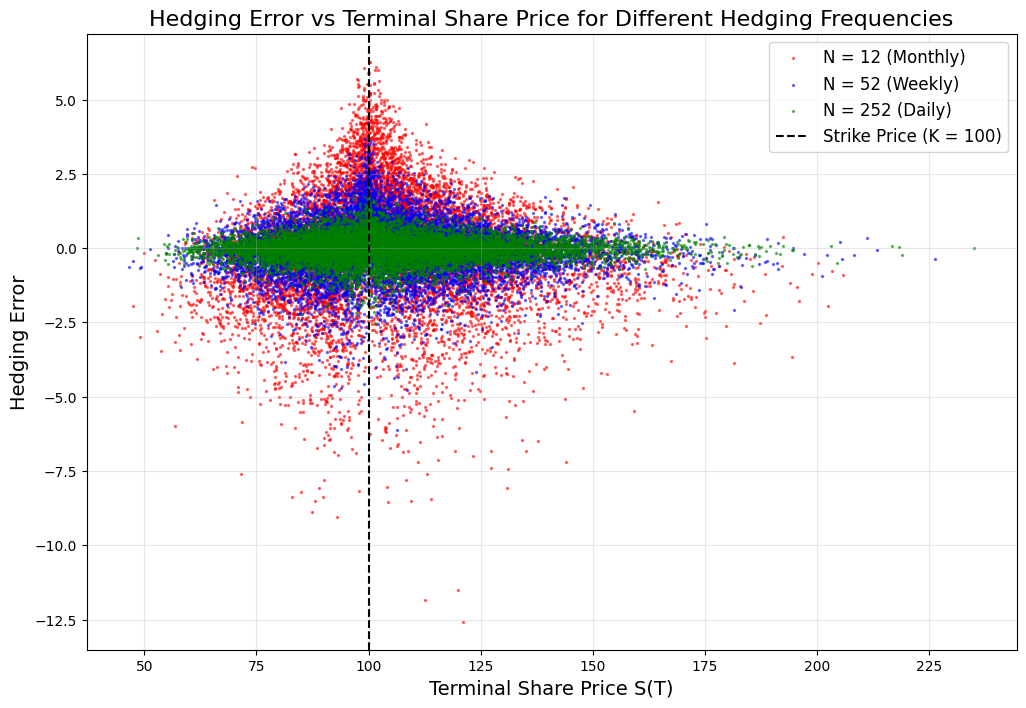

In [506]:
# Plotting the hedging error vs terminal share price for different N values
plt.figure(figsize=(12, 8))

colors = ['red', 'blue', 'green']
labels = ['N = 12 (Monthly)', 'N = 52 (Weekly)', 'N = 252 (Daily)']

for i, N in enumerate(N_values):
    plt.scatter(results[N]["Terminal Share Price"], results[N]["Replicating Error"],
                color=colors[i], s=2, alpha=0.5, label=labels[i])  # Small dots (s=5)

# Draw a vertical line at the strike price
plt.axvline(x=K, color='black', linestyle='--', linewidth=1.5, label=f"Strike Price (K = {K})")

# Add plot labels and legend
plt.title("Hedging Error vs Terminal Share Price for Different Hedging Frequencies", fontsize=16)
plt.xlabel("Terminal Share Price S(T)", fontsize=14)
plt.ylabel("Hedging Error", fontsize=14)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)
plt.show()

The hedging portfolio data can be plotted over side the payoff function to give an alternative representation to this hedging error as shown below.

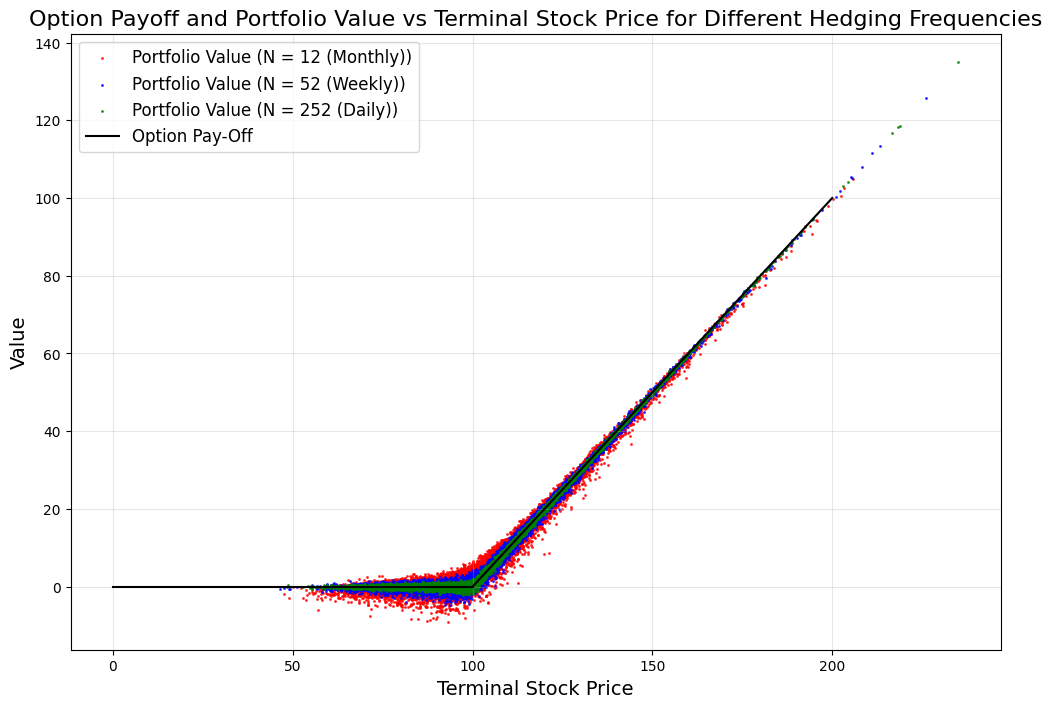

In [507]:
# Plot option payoff and portfolio value vs stock price for different N values
plt.figure(figsize=(12, 8))

colors = ['red', 'blue', 'green']
labels = ['N = 12 (Monthly)', 'N = 52 (Weekly)', 'N = 252 (Daily)']

for i, N in enumerate(N_values):
    plt.scatter(results[N]["Terminal Share Price"], results[N]["Portfolio Value"], color=colors[i], alpha=0.7, s=5, marker='.', label=f"Portfolio Value ({labels[i]})")

# Add a black line for value = 0 to 100
plt.plot([0, 100], [0, 0], color='black', linestyle='-', linewidth=1.5, label="Option Pay-Off")
plt.plot([100, 200], [0, 100], color='black', linestyle='-', linewidth=1.5)

# Add plot labels and legend
plt.title("Option Payoff and Portfolio Value vs Terminal Stock Price for Different Hedging Frequencies", fontsize=16)
plt.xlabel("Terminal Stock Price", fontsize=14)
plt.ylabel("Value", fontsize=14)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)
plt.show()

Hedging Frequency Impact:
The **hedging frequency** significantly influences the replication error. With lower frequencies (e.g., $N = 12$ or monthly hedging), the error is larger because the portfolio is adjusted less frequently, failing to capture rapid changes in the option’s delta caused by stock price movements. Conversely, with higher frequencies (e.g., $N = 252$ or daily hedging), the error is minimised as the portfolio closely tracks the option's delta, ensuring better replication. This demonstrates the trade-off between computational cost and accuracy in hedging strategies.

Strike Price Convexity Impact:
The **convexity near the strike price ($K = 100$)** amplifies hedging errors. Near the strike, the option’s gamma (sensitivity of delta to stock price changes) is highest, leading to rapid fluctuations in delta. These fluctuations require frequent rebalancing to maintain an effective hedge. If hedging frequency is insufficient, the error is magnified.

For each of these hedging frequencies $N$ we will calculate the mean and variance of the absolute hedging error as such:

In [508]:
summary_results = []

for N in N_values:
    mean_error = results[N]["Replicating Error"].abs().mean()
    variance_error = abs(results[N]["Replicating Error"]).var()
    summary_results.append([N, mean_error, variance_error])

summary_df = pd.DataFrame(summary_results, columns=["Hedging Frequency (N)", "Mean Abs Error", "Variance of Abs Error"])
summary_df.set_index("Hedging Frequency (N)", inplace=True)
display(summary_df)

,Mean Abs Error,Variance of Abs Error
Hedging Frequency (N),,
12,1.450456,1.569982
52,0.709336,0.394070
252,0.324350,0.083532


(f) Effect of $\mu$ on hedging error:

   - For each drift value ($\mu$), we simulate 10,000 paths using the `run_simulations` function.
   - Using a weekly hedging frequency ($N = 52$).
   - We calculate the **mean absolute error** and **variance of the hedging error** for each drift.

In [509]:
mu_values = [0.025, 0.05, 0.075, 0.10]  # Different drift values
mu_results = []

for mu in mu_values:
    df_results = run_simulations(K, S[0], r, mu, sigma, T, N=52, P=num_paths)
    mean_abs_error = df_results["Replicating Error"].abs().mean()
    variance_error = df_results["Replicating Error"].var()
    mu_results.append([mu, mean_abs_error, variance_error])

mu_summary_df = pd.DataFrame(mu_results, columns=["Drift (μ)", "Mean Absolute Error", "Variance of Hedging Error"])
mu_summary_df.set_index("Drift (μ)", inplace=True)
display(mu_summary_df)

,Mean Absolute Error,Variance of Hedging Error
Drift (μ),,
0.025,0.720947,0.914376
0.050,0.718468,0.921930
0.075,0.710316,0.895493
0.100,0.688162,0.847609


**Impact of Drift ($\mu$):**
   - The mean absolute error and variance of hedging error show **minor fluctuations** across different drift values.
   - For example, as $\mu$ increases from $2.5\%$ to $10\%$, the mean absolute error decreases slightly and then stabilises, while the variance exhibits minimal changes.

**Drift's Influence:**
   - These results suggest that **drift has a limited impact on hedging performance**. This aligns with expectations, as the hedging strategy primarily relies on short-term volatility ($\sigma$) rather than the long-term expected return ($\mu$).

**Key Observation:**
   - The small variations in hedging error with changing $\mu$ indicate that delta hedging remains effective regardless of the drift, making $\mu$ a secondary consideration for hedging strategies.

Transaction Costs

In this part, we utilise the functionaility implemetnted in `OptionSim` from **Question 1** to include round-trip transaction costs for each share purchase and sale. The transaction costs are defined as a percentage ($\phi$) of the stock price, which impacts the effective price of buying or selling shares.

Transaction Cost Mechanism:

1. **Buying Shares:**
   - When shares are purchased, the price is increased by $\phi/2$ to account for the bid-ask spread:
     $$
     \text{Transaction Price (Buy)} = S \cdot (1 + \phi / 2)
     $$

2. **Selling Shares:**
   - When shares are sold, the price is reduced by $\phi/2$:
     $$
     \text{Transaction Price (Sell)} = S \cdot (1 - \phi / 2)
     $$

As previously stated `OptionSim` already contains the following functionality accounting for transaction costs and so we simply activate this by passing a non `None` $\phi$ as argument:

```python
        if phi is not None:
            if shares_to_buy > 0:  # Buy shares
                transaction_price = S[t] * (1 + phi / 2)
            else:  # Sell shares
                transaction_price = S[t] * (1 - phi / 2)
            cash_balance -= shares_to_buy * transaction_price
        else:
            cash_balance -= shares_to_buy * S[t]

        shares_held = delta
        cash_balance *= (np.exp(r * dt))
```

We will simulate the dynamic hedging strategy $10,000$ this time for each $N=[12,52,252]$ and $\phi = [0.5\%, 1\%, 2\%]$ and calculate the Mean Hedging Error in each case.

In [510]:
# Run simulations for different hedging frequencies and transaction costs
phi_values = [0.005, 0.01, 0.02]  # Transaction cost percentages (0.5%, 1.0%, 2.0%)
P = 1000

# Run simulations for different hedging frequencies and transaction costs
summary_results = []

for phi in phi_values:
    for N in N_values:
        df_results = run_simulations(K, S[0], r, mu=r, sigma=sigma, T=T, N=N, P=num_paths, phi=phi)
        mean_abs_error = df_results["Replicating Error"].mean()
        summary_results.append([N, phi, mean_abs_error])

# Create a DataFrame for the summary results and set "Hedging Frequency (N)" and "Transaction Cost (φ)" as the index
summary_df = pd.DataFrame(summary_results, columns=["Hedging Frequency (N)", "Transaction Cost (φ)", "Mean Absolute Hedging Error"])
summary_df_pivot = summary_df.pivot(index="Hedging Frequency (N)", columns="Transaction Cost (φ)", values="Mean Absolute Hedging Error")
print("Summary of Mean Absolute Hedging Error with Transaction Costs (Two-Way Table):")
display(summary_df_pivot)

Summary of Mean Absolute Hedging Error with Transaction Costs (Two-Way Table):


Transaction Cost (φ),0.005,0.010,0.020
Hedging Frequency (N),,,
12,-0.579837,-1.181654,-2.381181
52,-0.899715,-1.800982,-3.575834
252,-1.580996,-3.152714,-6.320914


We visulaise this table with a heatmap below.

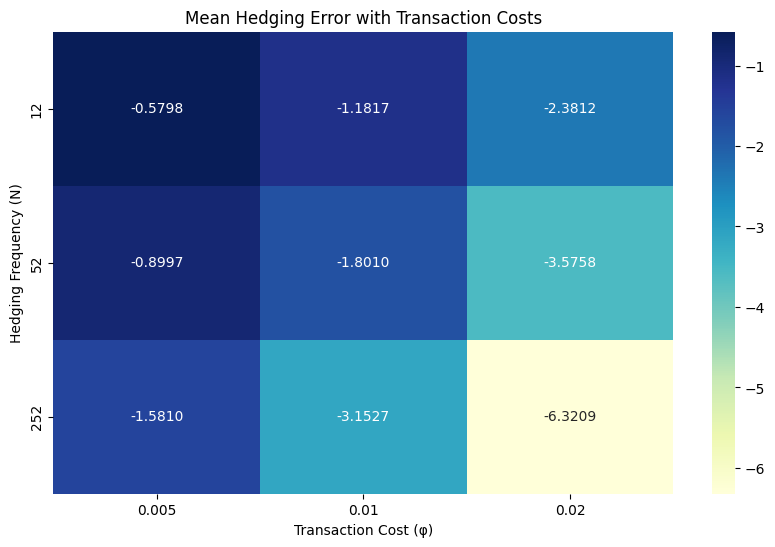

In [511]:
# Plot the results as a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(summary_df_pivot, annot=True, cmap="YlGnBu", fmt=".4f")
plt.title("Mean Hedging Error with Transaction Costs")
plt.xlabel("Transaction Cost (φ)")
plt.ylabel("Hedging Frequency (N)")
plt.show()

Leland (Journal of Finance, 1985) introduced an adjustment to the volatility ($\sigma$) to account for transaction costs during hedging. The adjusted volatility ($\sigma_{\text{Adjusted}}$) is given by:

$$
\sigma_{\text{Adjusted}} = \sigma \left( 1 + \sqrt{\frac{2N}{\pi}} \cdot \frac{\phi}{\sigma} \right)^{\frac{1}{2}}
$$

Where:
- $\phi$: Round-trip transaction cost as a percentage of the stock price,

In [512]:
# Function to adjust volatility using Leland's model
def leland_adjusted_volatility(sigma, phi, N):
    return sigma * (1 + np.sqrt((2 * N) / np.pi) * (phi / sigma)) ** 0.5

This formula incorporates the cost of hedging into the volatility parameter, effectively increasing it to reflect the impact of transaction costs. By using $\sigma_{\text{Adjusted}}$, the Black-Scholes model can capture the additional expense incurred due to frequent trading. This adjustment enables a simplified approach to assess the effect of transaction costs on option prices.

In [513]:
# Compare Leland's adjusted volatility prices to original Black-Scholes prices
bs_price_original = bs_value(S[0], T, K, r, 0, sigma, OptionTypes.EUROPEAN_CALL.value)

for phi in phi_values:
    for N in N_values:
        adjusted_sigma = leland_adjusted_volatility(sigma, phi, N)
        bs_price_adjusted = bs_value(S[0], T, K, r, 0, adjusted_sigma, OptionTypes.EUROPEAN_CALL.value)
        print(f"Hedging Frequency (N): {N}, Transaction Cost (φ): {phi}")
        print(f"Original Black-Scholes Price: {bs_price_original:.4f}, Adjusted Black-Scholes Price (Leland's Model): {bs_price_adjusted:.4f}")
        print(f"Price Increase: {bs_price_adjusted - bs_price_original:.4f}\n")

Hedging Frequency (N): 12, Transaction Cost (φ): 0.005
Original Black-Scholes Price: 10.4506, Adjusted Black-Scholes Price (Leland's Model): 10.7057
Price Increase: 0.2552

Hedging Frequency (N): 52, Transaction Cost (φ): 0.005
Original Black-Scholes Price: 10.4506, Adjusted Black-Scholes Price (Leland's Model): 10.9731
Price Increase: 0.5225

Hedging Frequency (N): 252, Transaction Cost (φ): 0.005
Original Black-Scholes Price: 10.4506, Adjusted Black-Scholes Price (Leland's Model): 11.5608
Price Increase: 1.1102

Hedging Frequency (N): 12, Transaction Cost (φ): 0.01
Original Black-Scholes Price: 10.4506, Adjusted Black-Scholes Price (Leland's Model): 10.9532
Price Increase: 0.5026

Hedging Frequency (N): 52, Transaction Cost (φ): 0.01
Original Black-Scholes Price: 10.4506, Adjusted Black-Scholes Price (Leland's Model): 11.4650
Price Increase: 1.0144

Hedging Frequency (N): 252, Transaction Cost (φ): 0.01
Original Black-Scholes Price: 10.4506, Adjusted Black-Scholes Price (Leland's Mod

Variance Swaps

This part involves simulating and dynamically hedging a 1-year variance swap based on a lognormal stock price process. Below are the steps corresponding to each part of the question:

(a) We use the `gbm` function to simulate a lognormal stock price process for 1 year, dynamically hedging the variance swap. The function `variance_swap_hedging` computes the P&L for each simulated path.

(b) Assumptions:
- **Initial stock price**: $S_0 = 100$
- **Volatility**: $\sigma = 0.30$
- **Growth rate**: $\mu = 0.05$
- **Hedging frequency**: $N = 252$ (daily hedging for a 1-year process).

In [515]:
# Parameters
S = np.array([100])
sigma = 0.3         
T = 1.0
mu = 0.05
N = 252

(c) Net Proceeds of Dynamic Hedging:
The net proceeds are computed using the dynamic hedging strategy, which invests $2/T$ dollars per day in the stock. The proceeds account for the payoff of the variance swap.

(d) Log Contract:
The log contract cost is computed as:
$$
\text{Log Contract Cost} = \sum \left( \frac{\Delta S_t}{S_t}\right) - 0.5 \cdot \sigma^2_{\text{realised}} \cdot T
$$
This cost is incorporated into the overall P&L.

In [ ]:
def variance_swap_hedging(S_0, sigma, mu, T, N, paths):
    PnL = np.zeros(paths)
    for i in range(paths):
        S = gbm(S_0, mu, sigma, T, N)
        log_returns = np.diff(np.log(S))
        realized_variance = np.sum(log_returns**2) / T
        expected_variance = sigma**2
        variance_notional = 2 / T

        log_contract_cost = np.sum((1 / S[:-1]) * np.diff(S)) - 0.5 * realized_variance * T
        dynamic_hedging_payoff = variance_notional * (realized_variance - expected_variance)

        PnL[i] = log_contract_cost + dynamic_hedging_payoff

    return PnL

In [516]:
PnL = variance_swap_hedging(S[0], sigma, mu, T, N, paths=10000)
print(f"PnL for first 10 paths: {PnL}")

PnL for first 10 paths: [-0.28626275 -0.3644132  -0.47248612 ... -0.27465569 -0.46173631
 -0.04260861]


(e) Histogram of Final P&L:
The histogram of the P&L distribution provides insights into the outcomes of the variance swap hedging strategy.

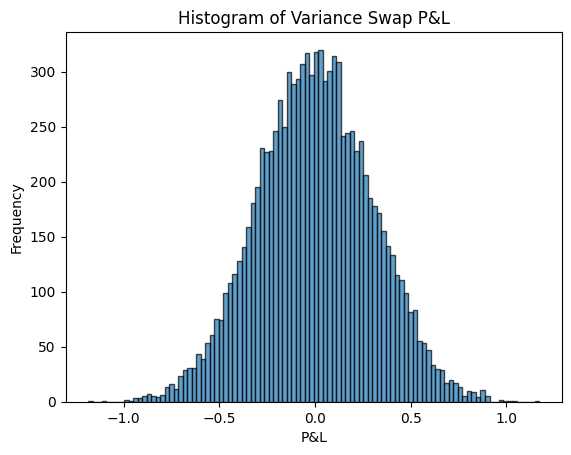

In [517]:
plt.hist(PnL, bins=100, edgecolor='k', alpha=0.7)
plt.title("Histogram of Variance Swap P&L")
plt.xlabel("P&L")
plt.ylabel("Frequency")
plt.show()

Swap and Swaption Pricing

In [ ]:
def bootstrap_discount_factors(swap_rates, maturities, frequency=2):
    delta = 1 / frequency  # Time increment for semi-annual payments
    discount_factors = {0: 1}
    
    for i, maturity in enumerate(maturities):
        swap_rate = swap_rates[i] / 100
        annuity = sum([discount_factors[time] * delta for time in discount_factors if time < maturity])
        discount_factor = (1 - swap_rate * annuity) / (1 + swap_rate * delta)
        discount_factors[maturity] = discount_factor
    
    return discount_factors

In [ ]:
def reprice_swaps(swap_rates, maturities, discount_factors, frequency=2):
    delta = 1 / frequency
    repricing_values = []
    for i, maturity in enumerate(maturities):
        swap_rate = swap_rates[i] / 100
        annuity = sum([
            discount_factors[time] * delta for time in discount_factors if time <= maturity
        ])
        swap_value = swap_rate * annuity - (1 - discount_factors[maturity])
        repricing_values.append(swap_value)
    return repricing_values

In [556]:
swap_rates = [2.3, 2.6, 2.86, 3.03, 3.18, 3.25]
maturities = [1, 2, 3, 5, 7, 10]

discount_factors = bootstrap_discount_factors(swap_rates, maturities)
print("Discount Factors:", discount_factors)

repricing_values = reprice_swaps(swap_rates, maturities, discount_factors)
print("Repricing Values (should be close to 0):", repricing_values)

results_df = pd.DataFrame({
    "Maturity (Years)": maturities,
    "Swap Rate (%)": swap_rates,
    "Discount Factor": [discount_factors[maturity] for maturity in maturities],
    "Repricing Value": repricing_values
})
display(results_df)


Discount Factors: {0: 1, 1: 0.977261492832427, 2: 0.9617923006842829, 3: 0.9444656716481425, 5: 0.9271188298308156, 7: 0.909056847238477, 10: 0.8925510001856778}
Repricing Values (should be close to 0): [-6.245004513516506e-17, 1.3183898417423734e-16, -6.245004513516506e-17, -2.7755575615628914e-17, -6.938893903907228e-17, -9.71445146547012e-17]


,Maturity (Years),Swap Rate (%),Discount Factor,Repricing Value
0,1,2.30,0.977261,-6.245005e-17
1,2,2.60,0.961792,1.318390e-16
2,3,2.86,0.944466,-6.245005e-17
3,5,3.03,0.927119,-2.775558e-17
4,7,3.18,0.909057,-6.938894e-17
5,10,3.25,0.892551,-9.714451e-17


In [ ]:
def swap_pv01(discount_factors, start, end, delta):
    pv01 = 0  # Initialise the PV01 value
    for maturity in discount_factors:
        if start < maturity <= end:
            pv01 += delta * discount_factors[maturity]
    return pv01

def forward_rate(Z_T1, Z_T2, delta):
    return (Z_T1 - Z_T2) / (delta * Z_T2)

In [ ]:
Z_T1 = discount_factors[1]
Z_T2 = discount_factors[7]
delta = 0.5  # Semi-annual payment

forward = forward_rate(Z_T1, Z_T2, delta)

# Swap PV01 calculation
pv01 = swap_pv01(discount_factors, start=1, end=8, delta=delta)

# Display results
print(f"Z(T1) (1 Year): {Z_T1}")
print(f"Z(T2) (8 Years): {Z_T2}")
print(f"Forward Rate: {forward}")
print(f"Swap PV01: {pv01}")